# Create artifact from time series dataframe
Gets a .tsf or .csv with a time serie, convert int to np.dataframe and loads it to weights and biases (W&B)

## Set-up
Initial notebook setup and specific debugging and pre-configured cases selection
### VsCode update patch
Initial notebook setup when using VSCode

In [1]:
import sys
if '--vscode' in sys.argv:
    print("Executing inside vscode")
    import nbs_pipeline.utils.vscode  as vs
    vs.DisplayHandle.update = vs.update_patch

### Debugging variables
- `print_flag`. If `True` it adds debbuging messages in those functions that allows so (eg. `get_enc_embeddings`)
- `reset_kernel`. If `True` it resets the kernel by the end of the execution. Use only in case that memory management is needed.

In [2]:
print_flag = True
reset_kernel=False

## Preconfigurated cases selection
- `pre_configured_case`. If `True`, a preconfigured case will be selected, forcing the artifact to get the expected configuration based on the information in `config\*.yml` and `utils\config.py`.
- `case_id`. If `preconfigured_case` is `True`, it forces to select the configuration of the `case_id` preconfigured samples. The available preconfigured samples are shown in the next cell.
- `frequency_factor`. If `pre_configured_case` is `True`, frequency will be resampled by `config.freq*frequency_factor`
  `frequency_factor_change_alias`. If `pre_configured_case` is `True` and `frequency_factor != 1` then the dataset alias will be modified for adding the new frequency as suffix.

In [3]:
import utils.config as cfg_
cfg_.show_available_configs()

Available datasets: 
0 - monash_australian_electricity_demand_0
1 - monash_solar_4_seconds_0
2 - wikipedia_0
3 - traffic_san_francisco_0
4 - monash_solar_10_minutes_0
5 - etth1_0
6 - stumpy_abp_0
7 - stumpy_toy_0


In [4]:
pre_configured_case = True
case_id = 7
frequency_factor = 1
frequency_factor_change_alias = True

## Main code


In [5]:
import pandas as pd
import numpy as np
from fastcore.all import *
import wandb
from dvats.load import TSArtifact, infer_or_inject_freq
import pickle
import matplotlib
import matplotlib.pyplot as plt
from tsai.data.external import convert_tsf_to_dataframe
from tsai.utils import stack_pad

### Path and Artiffact configurattions
This notebook gets configuration from `config\base.yaml` and `config\01-dataset_artifact.yaml`

In [6]:
base_path = Path.home()

In [7]:
config = cfg_.get_artifact_config_sd2a(print_flag = False)
if pre_configured_case: 
    cfg_.force_artifact_config_sd2a(
        config = config, 
        id = case_id, 
        print_flag = print_flag, 
        both = print_flag, 
        frequency_factor = frequency_factor, 
        frequency_factor_change_alias = frequency_factor_change_alias
    )

Selecting  stumpy_toy_0
test_split: None
freq: 1h -> 1s
joining_train_test: False
missing_values_constant: None
artifact_name: Monash-Australian_electricity_demand -> toy
start_date: None
csv_config: {}
range_testing: None
use_wandb: True
resampling_freq: None
date_format: %Y-%m-%d %H:%M:%S
data_cols: [0] -> []
missing_values_technique: None
normalize_training: False
range_training: None
time_col: None
data_fpath: ~/data/australian_electricity_demand_dataset.tsf -> ~/data/toy.csv
date_offset: None
wandb_artifacts_path: ./data/wandb_artifacts


### Data Extraction

The data is assumed to come as a dataframe, either as a binarized  picke file or
as a csv file. It can also come as a `.tsf` file

#### Check file content (if wanted)

In [8]:
if print_flag:
    fpath=os.path.expanduser(config.data_fpath)
    print(fpath)
    try: 
        with open(fpath, 'r') as file:
            for _ in range(13):
                line = file.readline()
                print(line, end='')
        data, _, _, _, _ = convert_tsf_to_dataframe(fpath)
        print("Timestamp", data.start_timestamp)
    except Exception as e:
        print("Error while converting file. Maybe not a tsf: ", e)

/home/macu/data/toy.csv
T3,T2,T1
0.7418217407048813,0.6371797479205732,0.5651174160530583
0.7397310623320076,0.6294149853417309,0.49351340038822233
0.7187567854120941,0.5392199104076484,0.46934998330275307
0.7301690144996238,0.5776701391250909,0.4440996674413469
0.7524056920505833,0.5701801791118106,0.37300780215582824
0.7173686807875511,0.5439381598630367,0.4250306471976907
0.6828549014634744,0.5968434716370429,0.35396080886927506
0.7013592638393263,0.5281288533936315,0.2995819396437861
0.6411104193217257,0.5656793700127485,0.30444732370665484
0.6089596256371969,0.576548578046155,0.3270511350770369
0.6034718811428907,0.6077293874759166,0.35334613064970627
0.6556284395994489,0.7144243525282192,0.30579381196757144
Error while converting file. Maybe not a tsf:  Missing attribute section. Attribute section must come before data.


#### Extract data

In [9]:
ext = str(config.data_fpath).split('.')[-1]

if ext == 'pickle':
    df = pd.read_pickle(config.data_fpath)
    
elif ext in ['csv','txt']:
    df = pd.read_csv(config.data_fpath, **config.csv_config)
    
elif ext == 'tsf':
    data, _, _, _, _ = convert_tsf_to_dataframe(os.path.expanduser(config.data_fpath))
    config.update({'start_date': data.start_timestamp[0]}, allow_val_change=True)
    date_format = config.date_format
    df = pd.DataFrame(stack_pad(data.series_value).T)
    
else:
    raise Exception('The data file path has an unsupported extension')


In [10]:
if print_flag:
    print(f'File loaded successfully')
    print(df.shape)
    display(df.head())

File loaded successfully
(550, 3)


,T3,T2,T1
0,0.741822,0.637180,0.565117
1,0.739731,0.629415,0.493513
2,0.718757,0.539220,0.469350
3,0.730169,0.577670,0.444100
4,0.752406,0.570180,0.373008


#### Set the time column (if any) as index

In [11]:
if config.time_col is not None:
    if print_flag: print("time_col: "+str(config.time_col))
    
    if isinstance(config.time_col, int): 
        if print_flag: print("Op 1: time_col int")
        datetime = df.iloc[:, config.time_col]
    
    elif isinstance(config.time_col, list): 
        if print_flag: print("Op 2: time_col list")
        datetime = df.iloc[:, config.time_col].apply(lambda x: x.astype(str).str.cat(sep='-'), axis=1)
    
    index = pd.DatetimeIndex(datetime)
    
    if config.date_offset:
        index += config.date_offset
    
    df = df.set_index(index, drop=False)   
    
    #Delete Timestamp col
    col_name = df.columns[config.time_col]
    
    if print_flag: print("... drop Timestamp col " + str(col_name))
    
    df = df.drop(col_name, axis=1)
    
if print_flag: display(df.head())

,T3,T2,T1
0,0.741822,0.637180,0.565117
1,0.739731,0.629415,0.493513
2,0.718757,0.539220,0.469350
3,0.730169,0.577670,0.444100
4,0.752406,0.570180,0.373008


#### Set dataframe frequency

In [12]:
df = infer_or_inject_freq(
    df, 
    injected_freq=config.freq, 
    start_date=config.start_date, 
    format=config.date_format
)
if print_flag: print(df.index.freq)

<Second>


#### Select only the needed variables

In [13]:
# Subset of variables
if config.data_cols:
    if print_flag: print("data_cols: ", config.data_cols)
    df = df.iloc[:, config.data_cols]

if print_flag: print(f'Num. variables: {len(df.columns)}')

Num. variables: 3


#### Ensure data integrity

In [14]:
#Duplicated rows
if print_flag: print("df shape before dropping duplicates", df.shape)
df.drop_duplicates()
if print_flag: print("df shape after dropping duplicates", df.shape)
# Verificar si hay duplicados en el índice del dataframe
if df.index.duplicated().any():
    raise ValueError("Duplicated index names")

df shape before dropping duplicates (550, 3)
df shape after dropping duplicates (550, 3)


In [15]:
# Replace the default missing values by np.NaN
if config.missing_values_constant:
    df.replace(config.missing_values_constant, np.nan, inplace=True)

#### Show time series plot

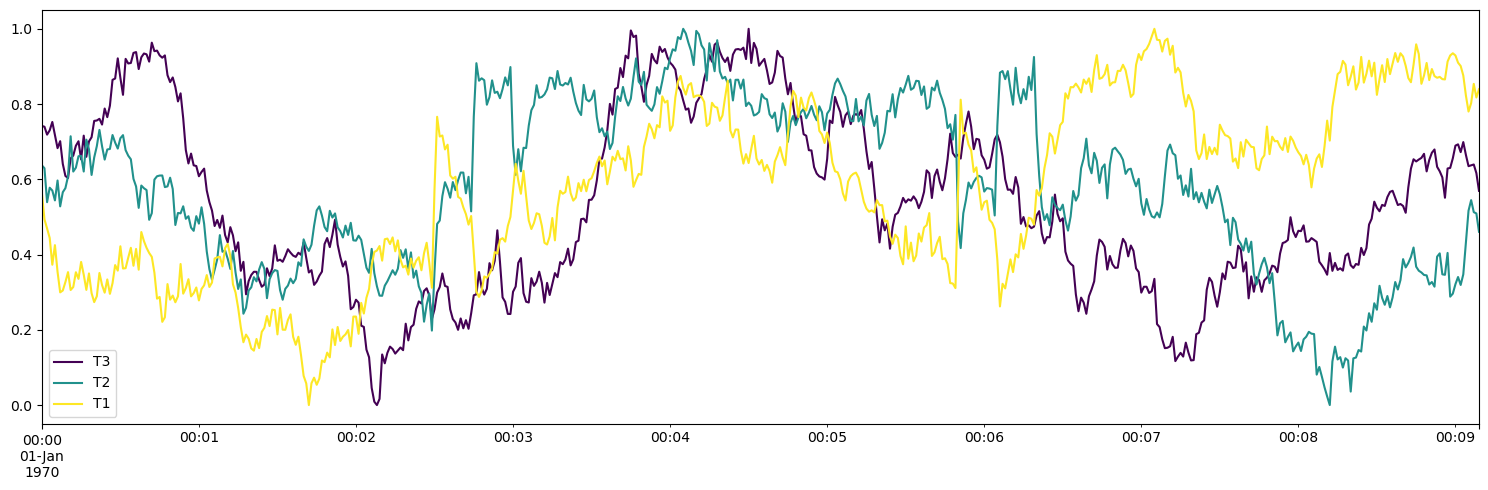

None

In [16]:
show_time_serie_flag = True
if show_time_serie_flag:
    # Show time series plot
    fig, ax = plt.subplots(1, figsize=(15,5), )
    cmap = matplotlib.colormaps.get_cmap('viridis')
    #df.plot(color=cmap(0.05), ax=ax) # or use colormap=cmap
    df.plot(colormap=cmap, ax=ax) # or use colormap=cmap
    # rect = Rectangle((5000, -4.2), 3000, 8.4, facecolor='lightgrey', alpha=0.5)
    # ax.add_patch(rect)
    plt.tight_layout()
    plt.legend()
    display(plt.show())

### Data Transformation

__Handle Missing Values, Resample and Normalize__

> In this second part, Time Series Artifact (TSArtifact) object can be created and missing values handling techniques, resampling and normalization can be applied.
> 
> This techniques should be applied on the three subsets that must be previously created: training, validation and testing.

#### Training data

##### Build dataframe

In [17]:
rg = config.range_training

if isinstance(rg, list):
    rg_training = rg
    
elif isinstance(rg, dict):
    rg_training = pd.date_range(rg['start'], rg['end'], freq=rg['freq'])
    
elif config.test_split:
    rg_training = df.index[:math.ceil(len(df) * (1-config.test_split))]

else:
    rg_training = None
    
df_training = df[df.index.isin(rg_training)] if rg_training is not None else df

##### Build training artifact

In [18]:
training_artifact = TSArtifact.from_df(
    df_training, 
    name=config.artifact_name, 
    missing_values_technique=config.missing_values_technique,
    resampling_freq=config.resampling_freq, 
    normalize=config.normalize_training, 
    path=str(Path.home()/config.wandb_artifacts_path)
)
if print_flag: display(training_artifact.metadata)

About to write df to  /home/macu/data/wandb_artifacts/2078634713863647172


{'TS': {'sd': '1970-01-01 00:00:00',
  'ed': '1970-01-01 00:09:09',
  'created': 'from-df',
  'n_vars': 3,
  'handle_missing_values_technique': 'None',
  'has_missing_values': 'False',
  'n_samples': 550,
  'freq': '<Second>',
  'vars': ['T3', 'T2', 'T1'],
  'hash': '2078634713863647172'}}

In [19]:
#Debugging 
if df_training.index.duplicated().any():
    raise ValueError("Duplicated index names")

#### Testing data

##### Build dataframe & artifact

In [20]:
# Testing data
rg = config.range_testing

if rg or config.test_split:
    
    if isinstance(rg, list):
        rg_testing = rg

    elif isinstance(rg, dict):
        rg_testing = pd.date_range(rg['start'], rg['end'], freq=rg['freq'])

    elif config.test_split:
        rg_testing = df.index[math.ceil(len(df) * (1 - config.test_split)):]

    else:
        rg_testing = None
    
    df_testing = df[df.index.isin(rg_testing)]
    testing_artifact = TSArtifact.from_df(df_testing,
                                          name=config.artifact_name, 
                                          missing_values_technique=config.missing_values_technique,
                                          resampling_freq=config.resampling_freq, 
                                          normalize=False,
                                          path=str(Path.home()/config.wandb_artifacts_path))
    display(testing_artifact.metadata)
    if df_testing.index.duplicated().any():
        print("Hay valores duplicados en el índice del dataframe.")
    else:
        print("No hay valores duplicados en el índice del dataframe.")
else:
    print("rg "+ str(rg) + " | test_split "+ str(config.test_split))
    testing_artifact = None

rg None | test_split None


#### Training + Testing data

##### Build dataframe & artifact

In [21]:
# Training + Testing data
if(config.joining_train_test):
    print("joining_train_test: "+ str(config.joining_train_test))
    df_train_test = pd.concat([df_training, df_testing])
    train_test_artifact = TSArtifact.from_df(df_train_test,
                                           name=config.artifact_name, 
                                           missing_values_technique=config.missing_values_technique,
                                           resampling_freq=config.resampling_freq, 
                                           normalize=False,
                                           path=str(Path.home()/config.wandb_artifacts_path))
    if df_train_test.index.duplicated().any():
        print("Hay valores duplicados en el índice del dataframe.")
    else:
        print("No hay valores duplicados en el índice del dataframe.")
    display(train_test_artifact.metadata)
else:
    train_test_artifact = None

### Storing artifacts

For the experiment tracking and hyperparameter we will use the tool **Weights & Biases**. 

> 
Before running this notebook part, make sure you have the `$WANDB_API_KEY`, `$WANDB_ENTITY` and `$WANDB_PROJECT` environment varibales defined with your API_KEY and your ENTITY and PROJECT names (run in a terminal `echo $WANDB_API_KEY` to see it, same with the other variables). If not, run in a terminal `wandb login [API_KEY]` to set the first one. You can see your API_KEY [here](https://wandb.ai/authorize) or in the settings of your W&B account. Run in a terminal `export WANDB_ENTITY=entity_name` and/or `export WANDB_PROJECT=project_name` to set the other two
> 
> <span style="color:red"> TODO: Modify config.ipynb so it gets wandb config from base.yml </span>.

In [22]:
import os
path = os.path.expanduser("~/work/nbs_pipeline/")
name="01_dataset_artifact"
os.environ["WANDB_NOTEBOOK_NAME"] = path+name+".ipynb"
runname=name
print("runname: "+runname)

runname: 01_dataset_artifact


In [23]:
mode = 'online' if config.use_wandb else 'disabled'

# Make the run that will produce the artifact
with wandb.init(job_type='create_dataset', resume=True, mode=mode, config=config, name=runname) as run:
    if testing_artifact: 
        run.log_artifact(training_artifact, aliases=['train'])
        run.log_artifact(testing_artifact, aliases=['test'])
        
        if train_test_artifact:
            run.log_artifact(train_test_artifact, aliases=['all'])
    
    else:
        run.log_artifact(training_artifact, aliases=['all'])

wandb: Currently logged in as: mi-santamaria. Use `wandb login --relogin` to force relogin


In [24]:
run.finish()

In [25]:
from dvats.imports import beep
print("Execution ended")
beep(1)

Execution ended


In [26]:
if reset_kernel:
    import os
    os._exit(00)